# Análise Exploratória de Dados (EDA) - Filmes do IMDb

**Objetivo:** Este notebook tem como objetivo explorar o dataset de filmes do IMDb para extrair insights sobre o que caracteriza um filme de alta avaliação e possiveis variáveis de interesse na construção do nosso modelo preditivo.  

A análise seguirá o seguinte roteiro:

1.  **Visão Geral dos Dados:** Carregar os dados e entender sua estrutura básica.
2.  **Análise Univariada:** Investigar a distribuição de cada variável individualmente.
3.  **Análise Multivariada:** Explorar as relações entre as variáveis.
4.  **Análise de Variáveis Categóricas:** Focar em Gênero, Diretor e Atores.
5.  **Análise de Texto (PLN):** Extrair informações das sinopses dos filmes.
6.  **Conclusão e Próximos Passos:** Sumarizar os achados e sugerir direções para modelagem.

### Configuração Inicial

In [ ]:
# Análise estatística
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# Análise textual
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np

# Partiremos do dataset já tratado
df = pd.read_csv('../data/processed/desafio_indicium_imdb_tratado.csv')

## 1. Visão Geral dos Dados

In [12]:
df.head()

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Has_Meta_Score,Has_Gross
0,The Godfather,1972.0,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0,1,1
1,The Dark Knight,2008.0,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0,1,1
2,The Godfather: Part II,1974.0,A,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0,1,1
3,12 Angry Men,1957.0,U,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0,1,1
4,The Lord of the Rings: The Return of the King,2003.0,U,201,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905.0,1,1


## 2. Análise Univariada

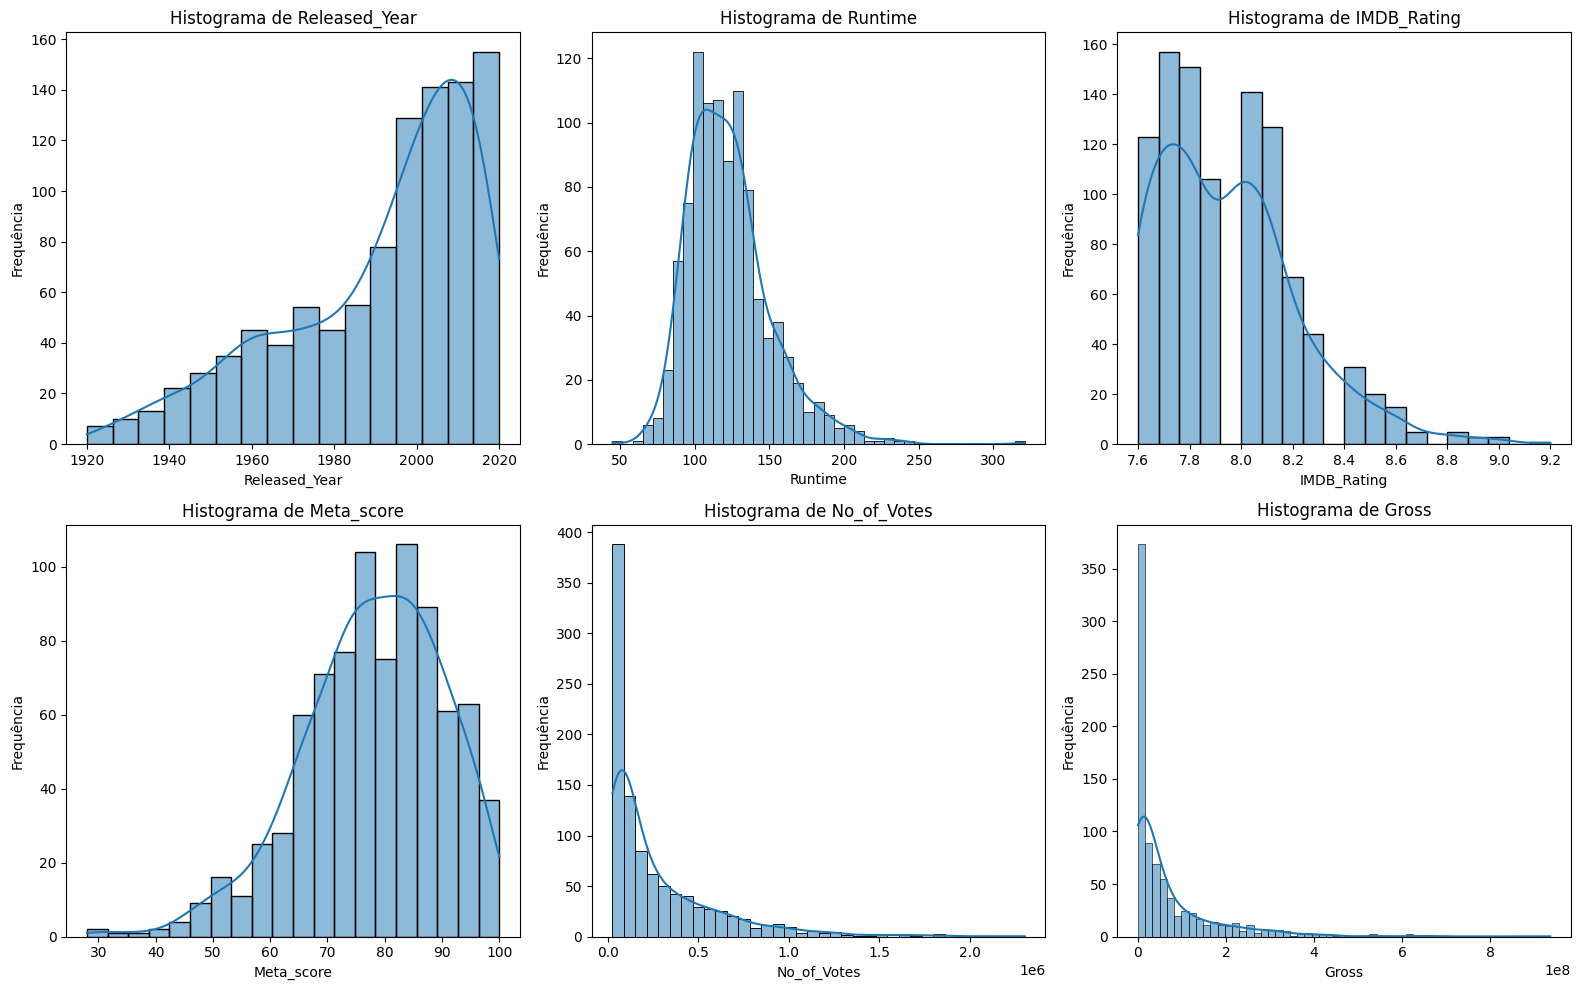

In [13]:
# Plotando histogramas para variáveis numéricas
columns = ['Released_Year', 'Runtime', 'IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Gross']

plt.figure(figsize=(16, 10))
for i, col in enumerate(columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

**Insights da Análise Univariada:**

- **`Runtime`:** A distribuição mostra uma concentração clara entre 90 e 130 minutos, com um pico em torno de 100-110 minutos.
- **`IMDB_Rating`:** As avaliações apresentam uma distribuição centrada entre 7.6 e 8.0, indicando que a maioria dos filmes recebe crítica positiva. A raridade de filmes com nota extremamente alta (>= 8.8) sugere que alcançar a excelencia crítica é um desafio significativo.
- **`Meta_score`:** Mostra uma concetração entre 70 e 85, com pico em torno de 80. A escasses de filmes com pontuação baixa (<= 50) sugere que a maioria das produções mantém um padrão mínimo de qualidade.
- **`Gross` e `No_of_Votes`:** Ambas as distribuições são altamente assimétricas à direita, o que significa que a maioria dos filmes tem arrecadação e número de votos modestos, enquanto poucos filmes (blockbusters) têm valores massivos.

## 3. Análise Bivariada e Multivariada

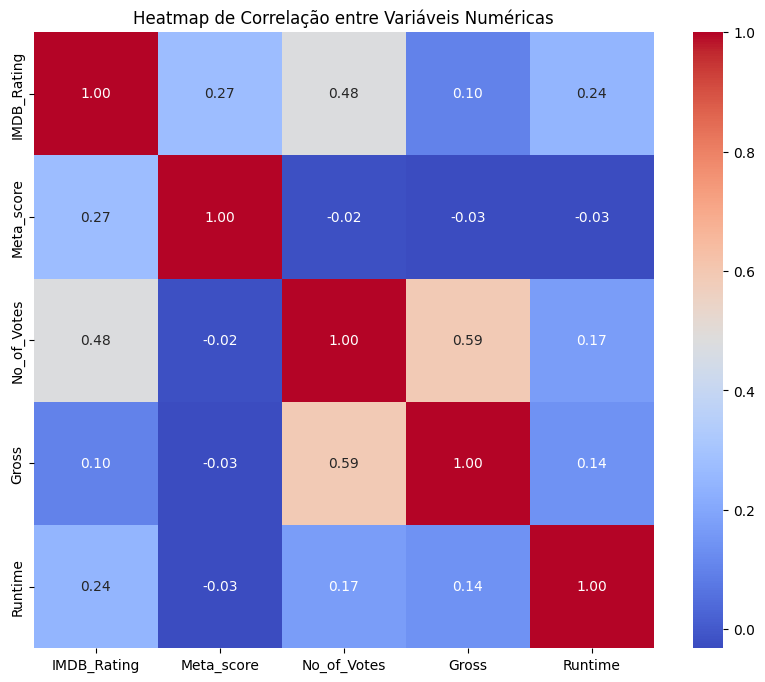

In [14]:
# Construindo heatmap de correlação entre variáveis numéricas
plt.figure(figsize=(10, 8))
correlation_matrix = df[['IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Gross', 'Runtime']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap de Correlação entre Variáveis Numéricas')
plt.show()

**Insights do Heatmap:**

- **`No_of_Votes` vs `Gross`** tem uma correlação moderada positiva (0.59), isso ja é esperado tendo em vista que filmes mais assistidos tendem a gerar mais dinheiro.
- **`No_of_Votes` vs `IMDB_Rating`** tem uma correlação moderada positiva (0.48), isso nos diz que filmes com alta participação do público tem avaliações mais altas.  
**Importante!:** Esta correlação não implica causalidade, pode haver viés de popularidade em vez de qualidade intríseca.

- Todas as outras correlações presentes no heatmap são fracas e não possuem informações relevantes para serem extraídas.

## 4. Análise de Variáveis Categóricas

### Gênero

/tmp/ipykernel_115886/415974969.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')


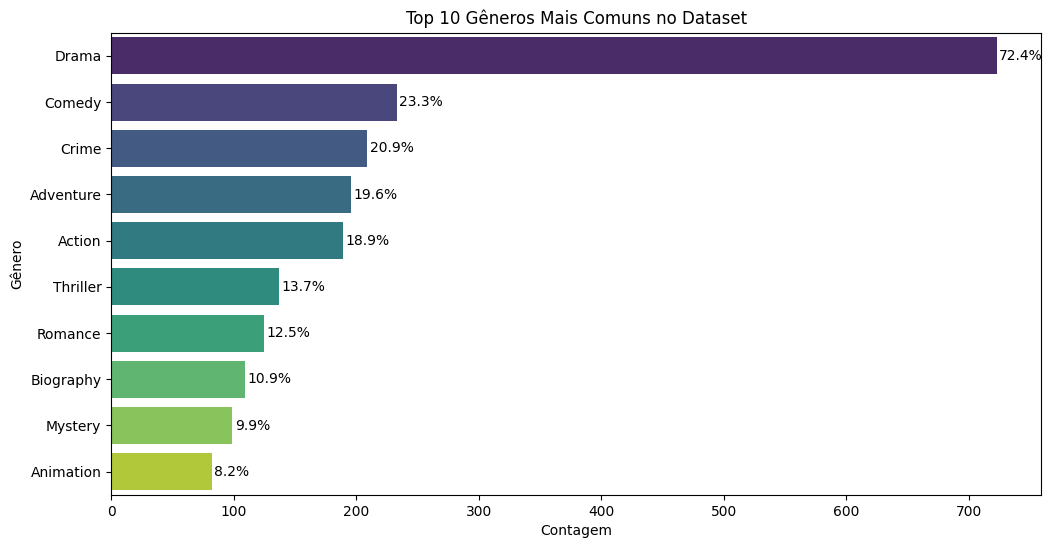

In [16]:
genres = df['Genre'].str.split(', ').explode()
top_genres = genres.value_counts().nlargest(10)

plt.figure(figsize=(12, 6))

# Calcula a porcentagem de cada gênero em relação ao total de filmes
percent = (top_genres / len(df)) * 100

# Adiciona os valores de porcentagem nas barras
for i, (count, pct) in enumerate(zip(top_genres.values, percent.values)):
    plt.text(count + 2, i, f'{pct:.1f}%', va='center')
sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')
plt.title('Top 10 Gêneros Mais Comuns no Dataset')
plt.xlabel('Contagem')
plt.ylabel('Gênero')
plt.show()

**Insight:** O gênero **Drama** é, de longe, o mais comum, presente em mais da metade dos filmes do dataset. Isso reforça a ideia de que é o genero mais produzido possivelmente por possuir maior apelo emocional do público. Outro fator é que como todos os filmes possuem mais de um gênero, o **Drama** se encontra na maioria mesmo que não seja o principal, como em filmes de romance por exemplo.

/tmp/ipykernel_115886/3284377657.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=genre_df, x='IMDB_Rating', y='Genre', order=sorted_genres, palette='viridis')


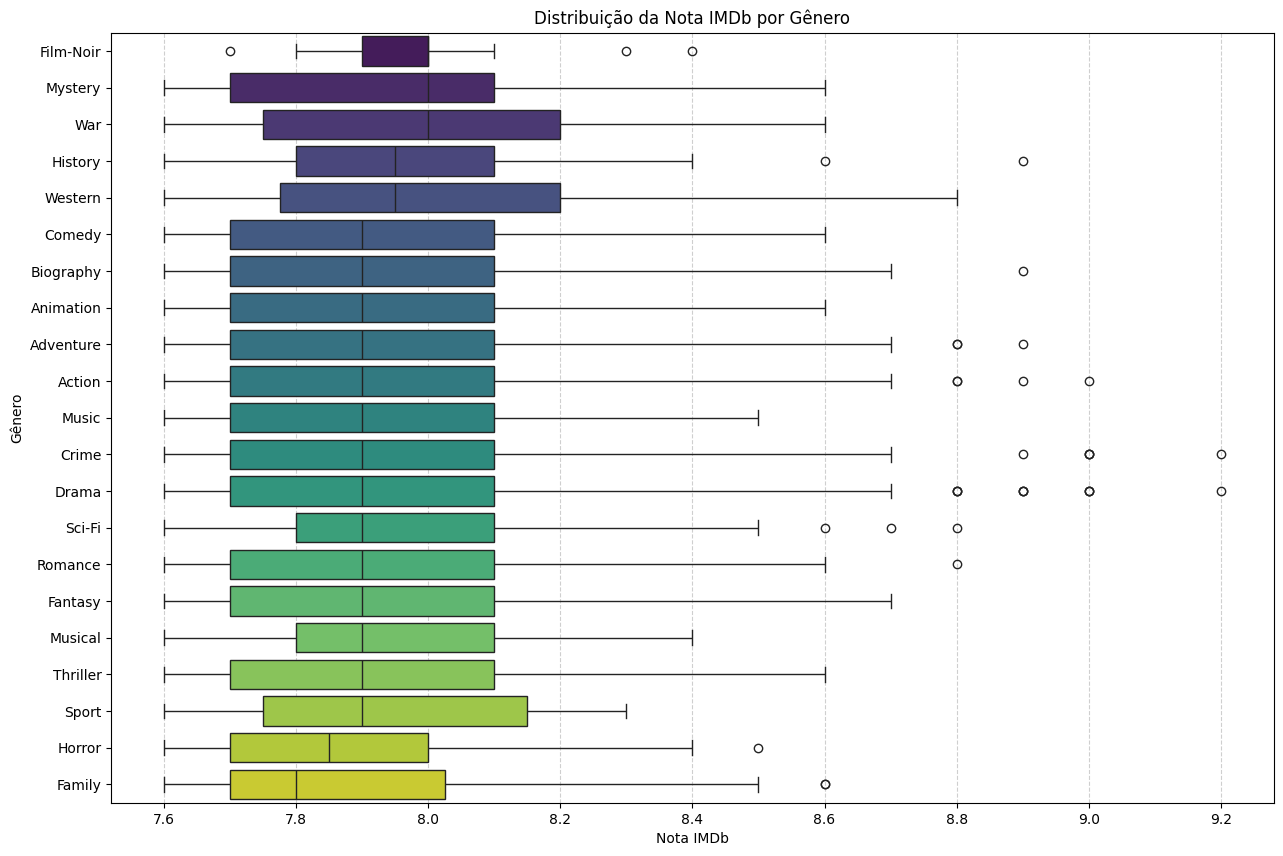

In [17]:
genre_df = df.assign(Genre=df['Genre'].str.split(', ')).explode('Genre')
sorted_genres = genre_df.groupby('Genre')['IMDB_Rating'].median().sort_values(ascending=False).index

plt.figure(figsize=(15, 10))
sns.boxplot(data=genre_df, x='IMDB_Rating', y='Genre', order=sorted_genres, palette='viridis')
plt.title('Distribuição da Nota IMDb por Gênero')
plt.xlabel('Nota IMDb')
plt.ylabel('Gênero')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

Esse plot mostra a variação de `IMDB_Rating` em cada genero, isso nos leva a duas conclusões:
- Estatisticamente existem diferenças significativas devido ao tamanho das amostras de cada genero, análise de médianas, numero de outliers, etc.
- Do ponto de vista prático, variações de 0.1-0.3 pontos na escala 0-10 não são relevantes para podermos concluir algo definitivo sobre a correlação do genero com a nota do IMDb.  

Apesar de não conseguirmos achar a correlação, alguns insights foram extraidos destes dados.

**Insights:**

- **Qualidade não está ligada à popularidade:** Gêneros como Film-Noir ou Mystery não são os mais populares, mas são os mais bem avaliados — indicando que artisticamente são mais valorizados.
- **Risco e recompensa em gêneros comerciais:** Gêneros como Action e Comedy têm alta variação — o que significa que investir nesses gêneros pode trazer grandes retornos se bem feitos, mas também riscos altos.
- **Filmes de "culto" em gêneros menos populares:** O fato de haver outliers altos em Horror, Musical e Family sugere que existe espaço para sucesso crítico fora do mainstream.
- **Consistência em gêneros narrativos:** Gêneros com foco em história (como Drama, Mystery, War) tendem a ser mais consistentes na qualidade, enquanto gêneros baseados em efeitos ou ritmo (Action, Horror) têm maior volatilidade.

### Diretor

/tmp/ipykernel_115886/1919364135.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_directors.values, y=top_directors.index, palette='viridis')


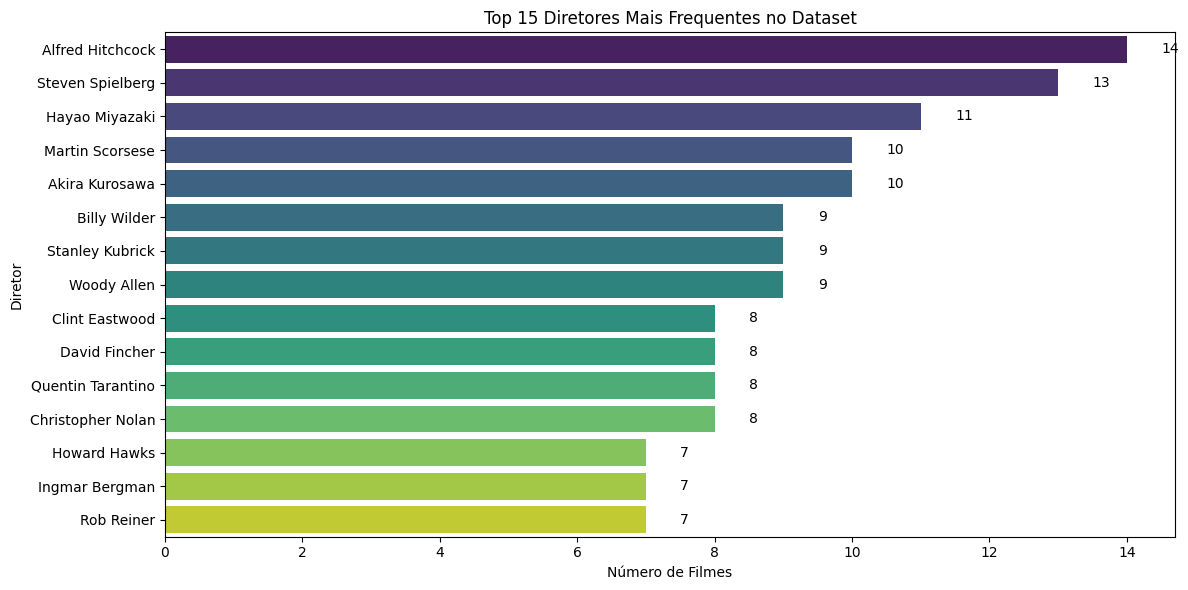

/tmp/ipykernel_115886/1919364135.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['Director'].isin(top_directors_list)], x='IMDB_Rating', y='Director', order=top_directors_list, palette='viridis')


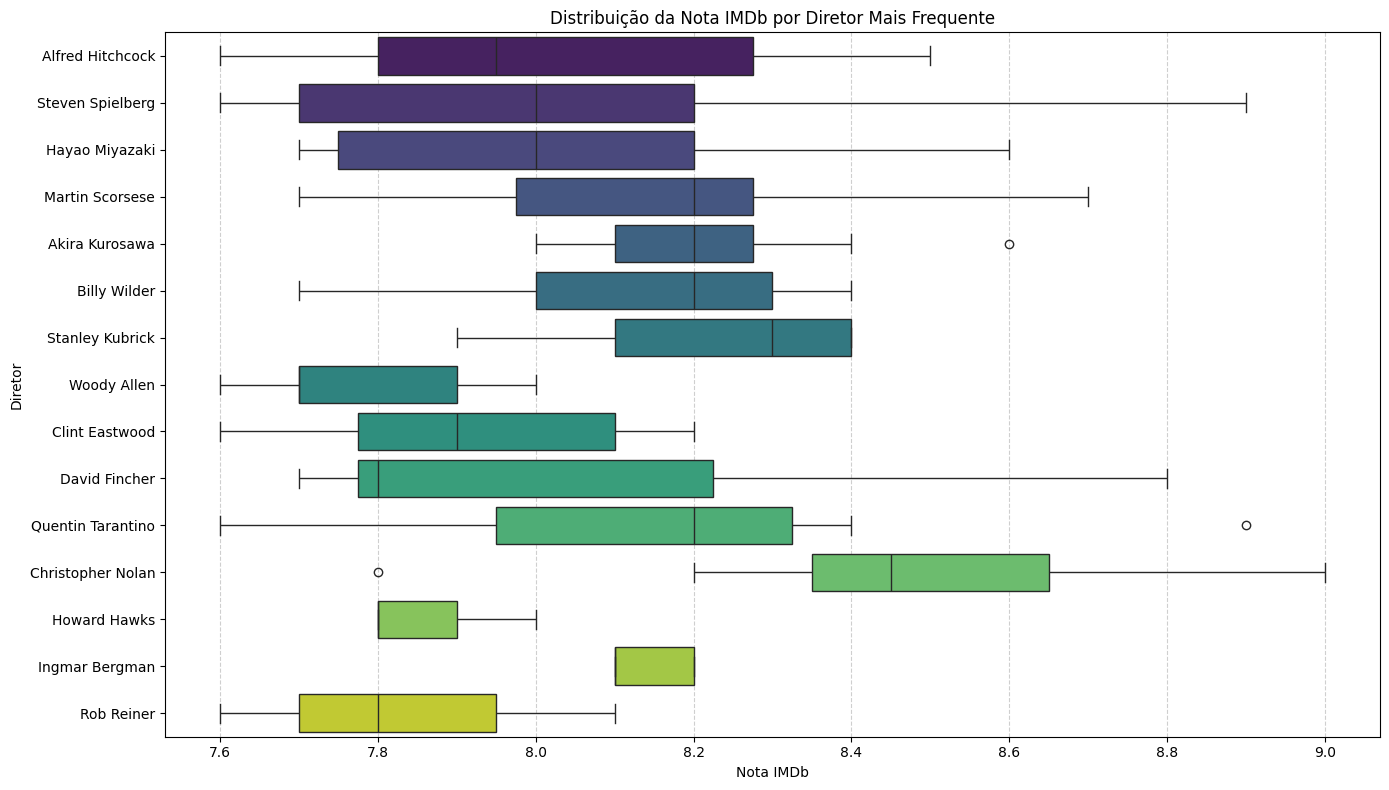

In [21]:
# Top 15 diretores mais frequentes
top_directors = df['Director'].value_counts().nlargest(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_directors.values, y=top_directors.index, palette='viridis')
plt.title('Top 15 Diretores Mais Frequentes no Dataset')
plt.xlabel('Número de Filmes')
plt.ylabel('Diretor')
for i, count in enumerate(top_directors.values):
    plt.text(count + 0.5, i, str(count), va='center')
plt.tight_layout()
plt.show()

# Boxplot: Distribuição das notas IMDb por diretor
top_directors_list = list(top_directors.index)
plt.figure(figsize=(14, 8))
sns.boxplot(data=df[df['Director'].isin(top_directors_list)], x='IMDB_Rating', y='Director', order=top_directors_list, palette='viridis')
plt.title('Distribuição da Nota IMDb por Diretor Mais Frequente')
plt.xlabel('Nota IMDb')
plt.ylabel('Diretor')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

O gráfico acima mostra os 15 diretores com maior nota média no IMDb, considerando apenas aqueles com 4 ou mais filmes no dataset. A escala está focada entre 8.0 e 8.6, o que permite visualizar com clareza a pequena variação entre os melhores.  

Aqui na análise de diretores tivemos uma variação de aproximadamente 0.35. Podemos dizer que tem a mesma variação encontrada na análise dos generos.

**Insights (Efeito Diretor):**

- Existe um claro "efeito diretor". Nomes como **Christopher Nolan**, **Quentin Tarantino**, e **Stanley Kubrick** não apenas aparecem com frequência, mas também mantêm uma nota média consistentemente alta (acima de 8.3).  
**Importante:** Com isso não é possivel afirmar que `Director` é um bom preditor para `IMDB_Rating`, esta análise mostra que a influência do diretor é mais forte em termos de consistencia do que de excelência.

### Atores

/tmp/ipykernel_115886/3616434874.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_actors.values, y=top_actors.index, palette='viridis')


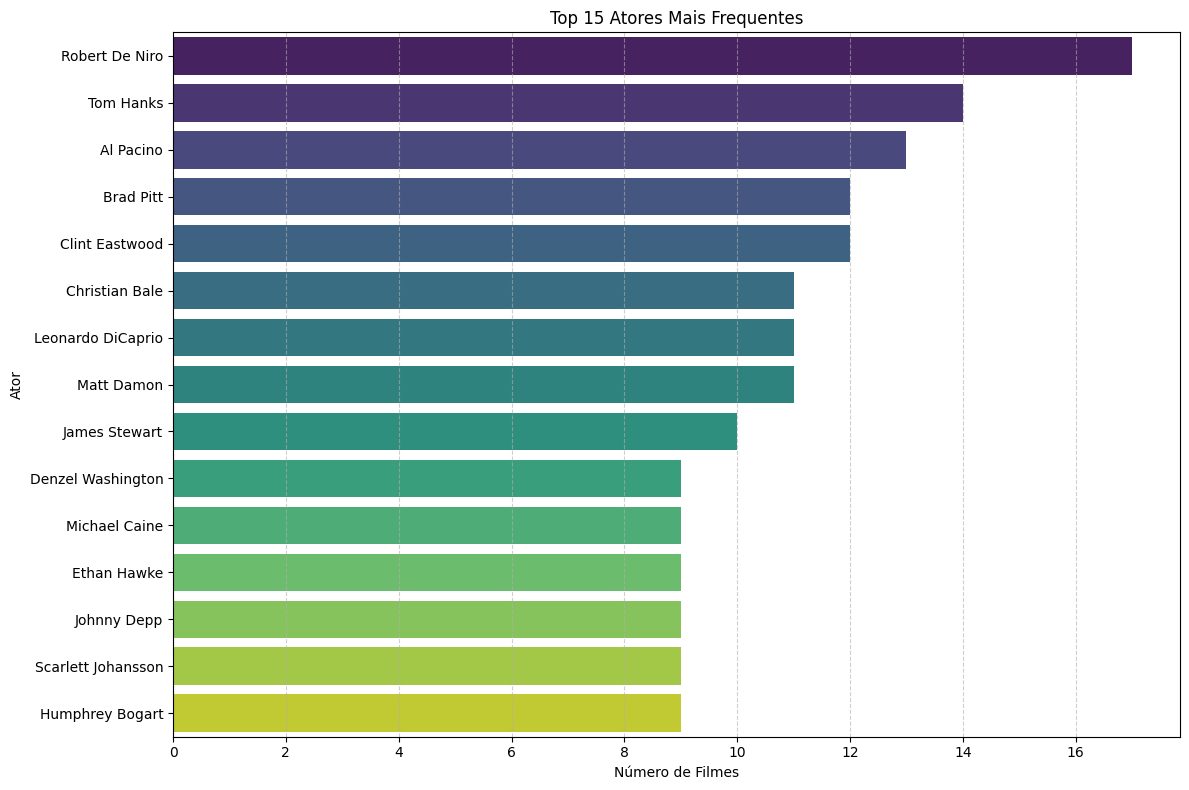

/tmp/ipykernel_115886/3616434874.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=actor_movies, x='IMDB_Rating', y='Actor', order=top_actors_names, palette='viridis')


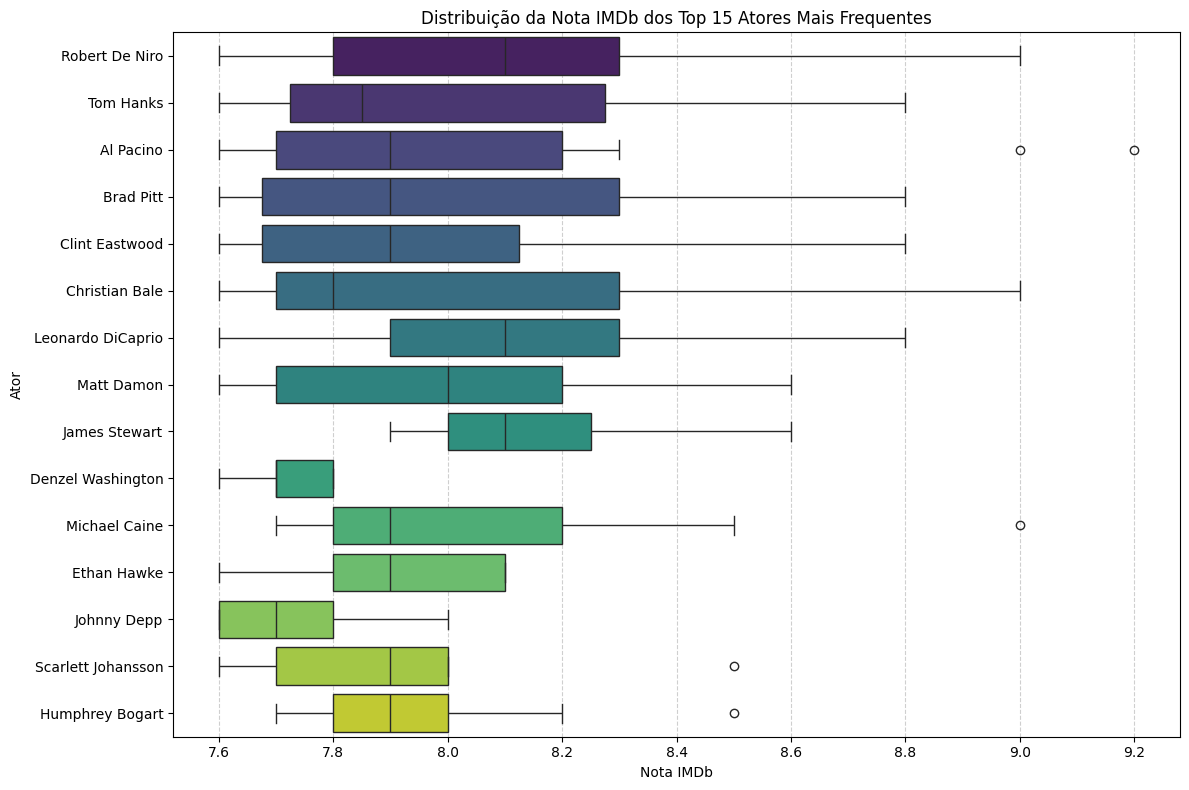

In [ ]:
# Selecionar os 15 atores mais frequentes
top_actors = actor_df['Actor'].value_counts().nlargest(15)

# Bar plot dos atores mais frequentes usando seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x=top_actors.values, y=top_actors.index, palette='viridis')
plt.title('Top 15 Atores Mais Frequentes')
plt.xlabel('Número de Filmes')
plt.ylabel('Ator')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Boxplot das notas IMDb para os 15 atores mais frequentes
top_actors_names = top_actors.index.tolist()
actor_movies = actor_df[actor_df['Actor'].isin(top_actors_names)]

plt.figure(figsize=(12, 8))
sns.boxplot(data=actor_movies, x='IMDB_Rating', y='Actor', order=top_actors_names, palette='viridis')
plt.title('Distribuição da Nota IMDb dos Top 15 Atores Mais Frequentes')
plt.xlabel('Nota IMDb')
plt.ylabel('Ator')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Podemos fazer a mesma análise que foi feita com os diretores. Os valores apesar de terem uma variação maior entre sí, não variam muito no que diz respeito a métrica nota do IMDb. Outro fato relevante é que diferente dos diretores não temos nenhum ator claramente acima da média, mesmo que as medianas não sejam as mesmas suas variações seguem a média.

**Insights (Efeito Ator):**

- **Robert De Niro** e **Tom Hanks** são os atores mais frequentes neste dataset de filmes de alta qualidade.
- Atores como **Leonardo DiCaprio** e **Christian Bale** estão associados a filmes com as maiores notas médias, indicando que sua presença pode ser um forte indicador de aclamação crítica e do público e não necessariamente um viés de qualidade significativo para a nota do IMDb.

### Classificação Indicativa

/tmp/ipykernel_2293/3214615068.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='IMDB_Rating', y='Certificate', order=sorted_certificates, palette='viridis')


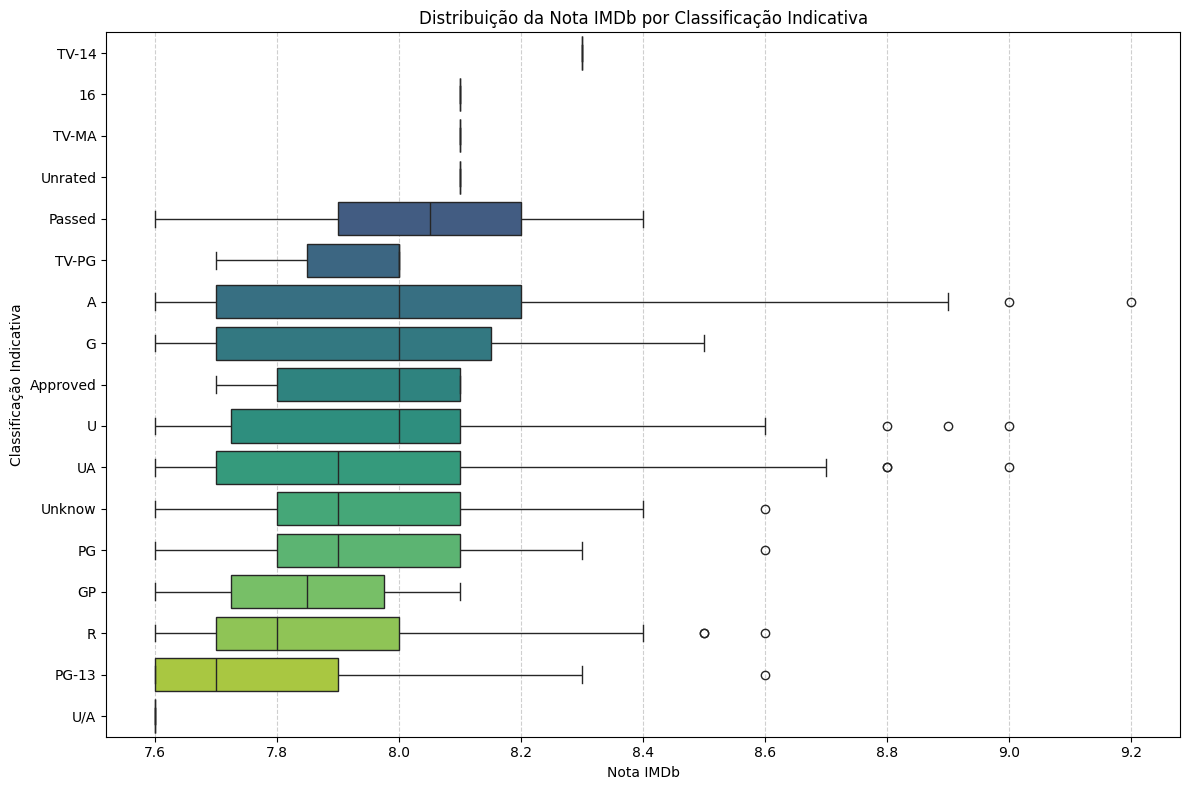

In [ ]:
# Ordenando por mediana da nota
sorted_certificates = df.groupby('Certificate')['IMDB_Rating'].median().sort_values(ascending=False).index

plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='IMDB_Rating', y='Certificate', order=sorted_certificates, palette='viridis')
plt.title('Distribuição da Nota IMDb por Classificação Indicativa')
plt.xlabel('Nota IMDb')
plt.ylabel('Classificação Indicativa')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Insights:**
- **G** e **A** possuem medianas mais elevadas mas não tão relevantes a ponto de influênciarem na variável alvo.
- Os dados tratados como **Unknow** representam uma parcela significativa mas se comportam dentro esperado sem comprometer a integridade do restante dos dados.

## 5. Análise de Texto (Overview)

Nossa análise de texto será dividida em três partes principais:

1. **Análise de Tópicos (NMF):** Para descobrir temas latentes nas sinopses
2. **Análise de Sentimento e Métricas Textuais:** Para entender aspectos estruturais e emocionais
3. **Análise de N-gramas:** Para identificar padrões frequentes em filmes bem avaliados

In [29]:
# Criar o vetorizador TF-IDF
tfidf = TfidfVectorizer(
    max_features=1000,  # Limitar para os 1000 termos mais frequentes
    stop_words='english',
    ngram_range=(1, 2)  # Incluir unigramas e bigramas
)

# Criar a matriz TF-IDF
tfidf_matrix = tfidf.fit_transform(df['Overview'])

# Criar modelo NMF para extrair tópicos
n_topics = 10
nmf = NMF(n_components=n_topics, random_state=42)
topic_matrix = nmf.fit_transform(tfidf_matrix)

# Obter os principais termos para cada tópico
def print_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words-1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        print(f"Tópico {topic_idx + 1}: {', '.join(top_words)}")

print("\nPrincipais tópicos encontrados nas sinopses:")
print_topics(nmf, tfidf.get_feature_names_out(), n_top_words=10)


Principais tópicos encontrados nas sinopses:
Tópico 1: man, young man, journey, prison, lawyer, takes, young, accident, doctor, mother
Tópico 2: war, world, world war, ii, war ii, german, american, jewish, battle, army
Tópico 3: life, live, tales, way, begins, finds, early, mysterious, live life, friend
Tópico 4: old, year, year old, home, old girl, girl, boy, old boy, 12, 12 year
Tópico 5: new, york, new york, city, york city, wife, real, agent, discovers, goes
Tópico 6: young, woman, young woman, search, boy, young man, young boy, children, help, freedom
Tópico 7: story, team, american, years, true, town, true story, tells, people, space
Tópico 8: love, falls, falls love, finds, girl, human, murder, detective, daughter, finds love
Tópico 9: family, father, son, daughter, save, crime, goes, tries, mother, death
Tópico 10: school, high, day, lives, high school, friends, students, teacher, time, teachers


A análise de texto através de tópicos foi escolhida devido ao conhecimento empírico associado de que as sinopses de generos especificos geralmente possuem termos recorrentes.  

O que podemos extrair da análise de tópicos é:
- **Tópico 1**: Muitos filmes focam em homens jovens enfrentando transformações pessoais (jornada do herói).
- **Tópico 2**: Temas de guerra, especialmente WW2, são muito frequentes.
- **Tópico 3**: Conteúdo mais contemplativo e voltado para o significado da existência.
- **Tópico 4**: Forte presença de histórias infantis e do passar do tempo do personagem.
- **Tópico 5**: Narrativas em grandes cidades (Nova York), muitas vezes com elementos de mistério.
- **Tópico 6**: Foco em personagens jovens como agentes de mudança.
- **Tópico 7**: Popularidade de biografias e histórias baseadas em fatos reais.
- **Tópico 8**: Combinação clássica de amor e suspense.
- **Tópico 9**: Forte carga emocional centrada na família
- **Tópico 10**: Universo escolar como cenário recorrente


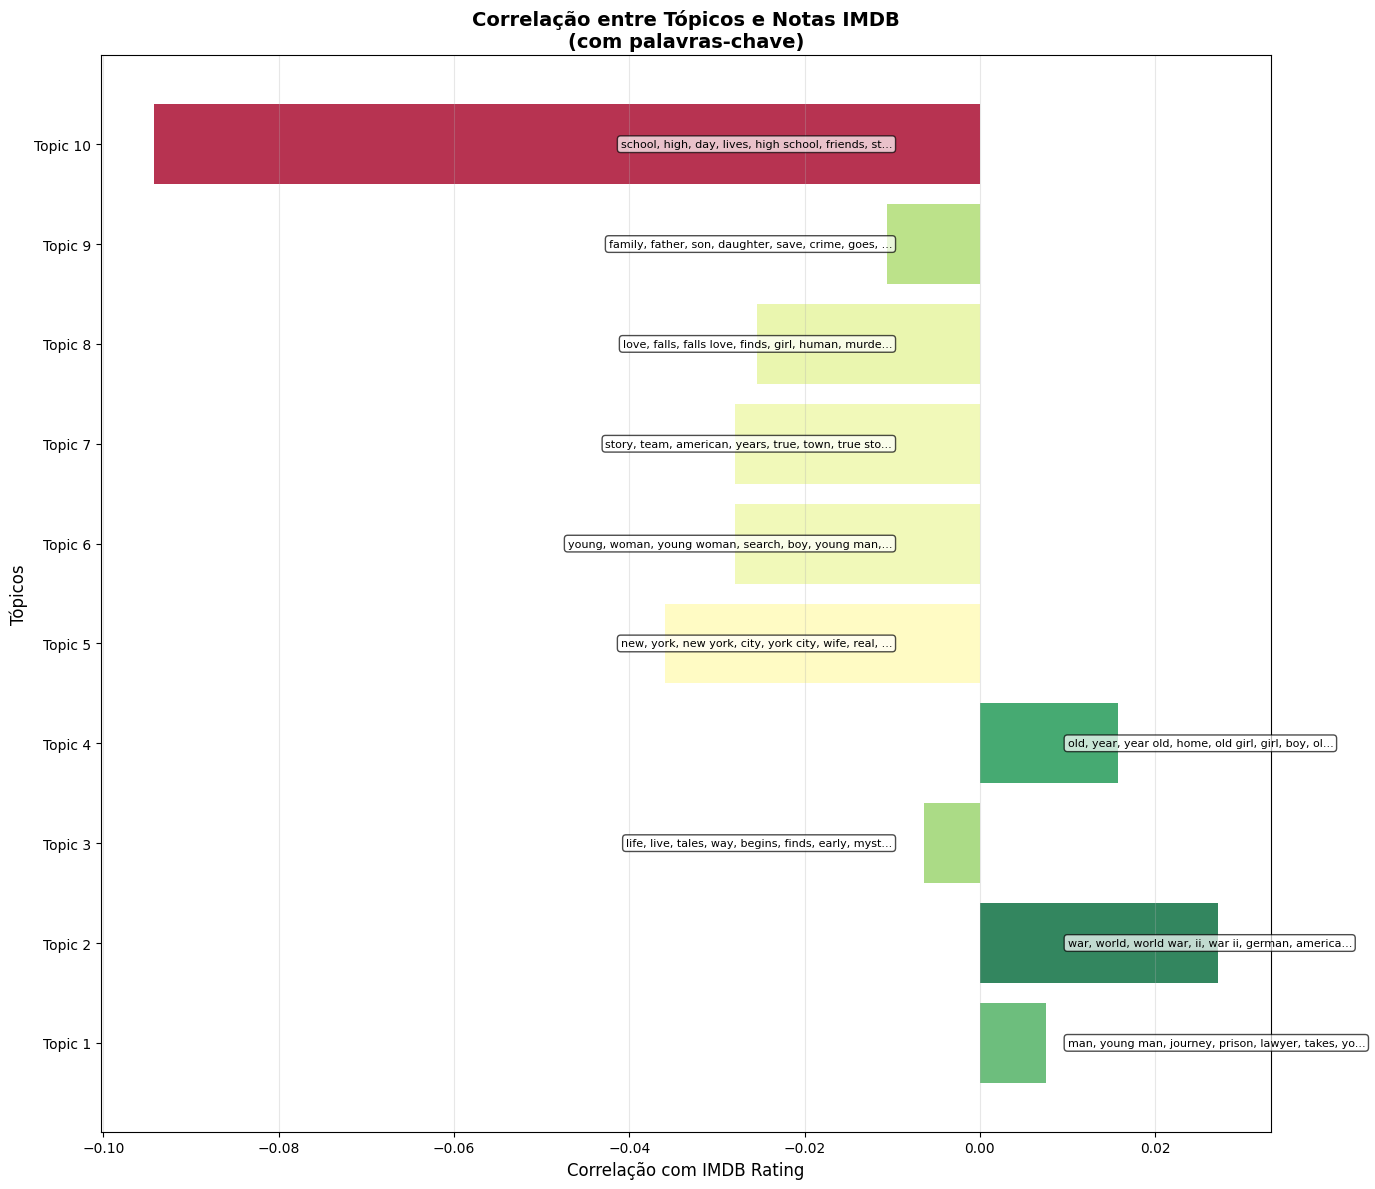


                         RESUMO DOS TÓPICOS E SUA RELAÇÃO COM AS NOTAS IMDB                         
Tópico     Correlação   Média Score  Palavras-Chave Principais
----------------------------------------------------------------------------------------------------
Topic 1    0.008        0.010        man, young man, journey, prison, lawyer,...
Topic 2    0.027        0.020        war, world, world war, ii, war ii, germa...
Topic 3    -0.006       0.021        life, live, tales, way, begins, finds, e...
Topic 4    0.016        0.016        old, year, year old, home, old girl, gir...
Topic 5    -0.036       0.019        new, york, new york, city, york city, wi...
Topic 6    -0.028       0.028        young, woman, young woman, search, boy, ...
Topic 7    -0.028       0.022        story, team, american, years, true, town...
Topic 8    -0.025       0.016        love, falls, falls love, finds, girl, hu...
Topic 9    -0.011       0.022        family, father, son, daughter, save, cri...
Topic

In [41]:
# Criar DataFrame com scores dos tópicos
topic_df = pd.DataFrame(
    topic_matrix,
    columns=[f'Topic_{i+1}' for i in range(n_topics)]
)
topic_df['IMDB_Rating'] = df['IMDB_Rating'].values  # Garantir alinhamento dos índices

# Calcular estatísticas para cada tópico
topic_stats = []
feature_names = tfidf.get_feature_names_out()

for idx, topic in enumerate(nmf.components_):
    top_words_idx = topic.argsort()[:-11:-1]  # Top 10 palavras
    top_words = [feature_names[i] for i in top_words_idx]
    
    # Calcular correlação do tópico com IMDB_Rating
    topic_corr = topic_df[f'Topic_{idx+1}'].corr(topic_df['IMDB_Rating'])
    
    # Calcular média do tópico
    topic_mean = topic_df[f'Topic_{idx+1}'].mean()
    
    topic_stats.append({
        'Topic': f'Topic {idx+1}',
        'Top_Words': ', '.join(top_words),
        'Correlation': topic_corr,
        'Mean_Score': topic_mean
    })

# Criar DataFrame com as estatísticas
stats_df = pd.DataFrame(topic_stats)


# Gráfico de barras horizontais com os tópicos
fig, ax2 = plt.subplots(figsize=(14, 12))

colors = plt.cm.RdYlGn((stats_df['Correlation'] - stats_df['Correlation'].min()) / 
                       (stats_df['Correlation'].max() - stats_df['Correlation'].min()))

bars = ax2.barh(range(len(stats_df)), stats_df['Correlation'], color=colors, alpha=0.8)

ax2.set_xlabel('Correlação com IMDB Rating', fontsize=12)
ax2.set_ylabel('Tópicos', fontsize=12)
ax2.set_title('Correlação entre Tópicos e Notas IMDB\n(com palavras-chave)', fontsize=14, fontweight='bold')
ax2.set_yticks(range(len(stats_df)))
ax2.set_yticklabels([f"{row['Topic']}" for _, row in stats_df.iterrows()])

# Adicionar tópicos como texto nas barras
for i, (bar, row) in enumerate(zip(bars, stats_df.iterrows())):
    words = row[1]['Top_Words'][:50] + "..." if len(row[1]['Top_Words']) > 50 else row[1]['Top_Words']
    ax2.text(0.01 if bar.get_width() >= 0 else -0.01, 
             bar.get_y() + bar.get_height()/2, 
             words, 
             ha='left' if bar.get_width() >= 0 else 'right', 
             va='center', 
             fontsize=8,
             bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))

ax2.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Tabela resumo
print("\n" + "="*100)
print("RESUMO DOS TÓPICOS E SUA RELAÇÃO COM AS NOTAS IMDB".center(100))
print("="*100)
print(f"{'Tópico':<10} {'Correlação':<12} {'Média Score':<12} {'Palavras-Chave Principais'}")
print("-"*100)

for _, row in stats_df.iterrows():
    correlation = f"{row['Correlation']:.3f}"
    mean_score = f"{row['Mean_Score']:.3f}"
    words = row['Top_Words'][:40] + "..." if len(row['Top_Words']) > 40 else row['Top_Words']
    print(f"{row['Topic']:<10} {correlation:<12} {mean_score:<12} {words}")

print("-"*100)

max_corr = stats_df.loc[stats_df['Correlation'].idxmax()]
min_corr = stats_df.loc[stats_df['Correlation'].idxmin()]

print(f"\n Tópico mais positivamente correlacionado: {max_corr['Topic']} (r={max_corr['Correlation']:.3f})")
print(f" Tópico mais negativamente correlacionado: {min_corr['Topic']} (r={min_corr['Correlation']:.3f})")

# Calcular estatísticas gerais
avg_correlation = stats_df['Correlation'].mean()
correlation_std = stats_df['Correlation'].std()

print(f"\n Correlação média: {avg_correlation:.3f} ± {correlation_std:.3f}")
print(f"Tópicos com correlação positiva: {len(stats_df[stats_df['Correlation'] > 0])}/{len(stats_df)}")


Após a análise dos tópicos e do calculo da correlação com a variável alvo `IMDB_Rating` podemos concluir que:
- A maior correlação (-0.094) ainda é baixo para indicar que existe uma influência (negativa) do tópico na nota do IMDb.
- Poucos tópicos obtiveram correlação positiva.


In [42]:
from textblob import TextBlob
import numpy as np

def extract_text_features(text):
    blob = TextBlob(text)
    
    # Características básicas do texto
    basic_features = {
        'text_length': len(text),
        'word_count': len(text.split()),
        'avg_word_length': np.mean([len(word) for word in text.split()]),
        'sentence_count': len(blob.sentences),
    }
    
    # Análise de sentimento
    sentiment_features = {
        'polarity': blob.sentiment.polarity,
        'subjectivity': blob.sentiment.subjectivity,
    }
    
    # Características complexas
    complex_features = {
        'words_per_sentence': basic_features['word_count'] / max(basic_features['sentence_count'], 1),
        'unique_words_ratio': len(set(text.split())) / max(basic_features['word_count'], 1),
    }
    
    return {**basic_features, **sentiment_features, **complex_features}

# Extrair features de todas as sinopses
text_features = df['Overview'].apply(extract_text_features).apply(pd.Series)
text_features['IMDB_Rating'] = df['IMDB_Rating']

# Visualizar correlações
plt.figure(figsize=(12, 8))
correlations = text_features.corr()['IMDB_Rating'].sort_values(ascending=False)
correlations = correlations.drop('IMDB_Rating')

sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
plt.title('Correlação entre Características Textuais e IMDB_Rating')
plt.xlabel('Coeficiente de Correlação')
plt.tight_layout()
plt.show()

# Imprimir insights sobre as correlações
print("\nPrincipais correlações encontradas:")
for feature, corr in correlations.items():
    if abs(corr) > 0.1:  # Mostrar apenas correlações relevantes
        print(f"{feature}: {corr:.3f}")

ModuleNotFoundError: No module named 'textblob'

/tmp/ipykernel_2293/3520488440.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_correlations.index[:-1], y=topic_correlations.values[:-1], palette='viridis')


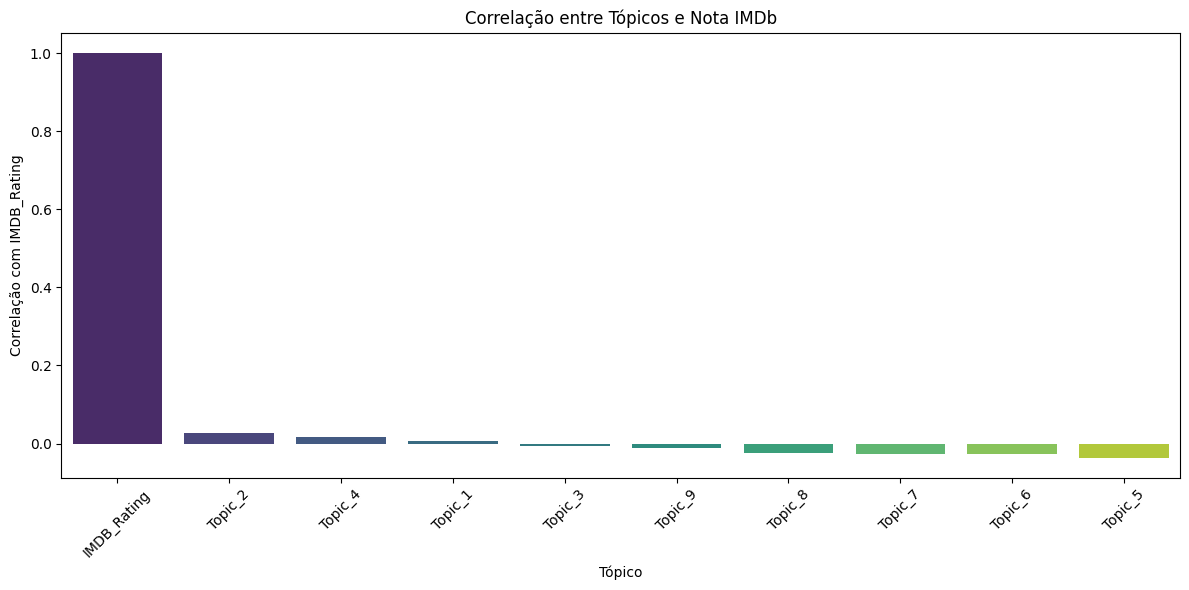


Tópicos mais correlacionados com notas altas do IMDb:

IMDB_Rating (correlação: 1.000):


ValueError: invalid literal for int() with base 10: 'Rating'

In [ ]:
# Criar DataFrame com os scores dos tópicos
topic_df = pd.DataFrame(
    topic_matrix,
    columns=[f'Topic_{i+1}' for i in range(n_topics)]
)

# Adicionar IMDB_Rating ao DataFrame
topic_df['IMDB_Rating'] = df['IMDB_Rating']

# Calcular correlação entre tópicos e IMDB_Rating
topic_correlations = topic_df.corr()['IMDB_Rating'].sort_values(ascending=False)

# Visualizar correlações
plt.figure(figsize=(12, 6))
sns.barplot(x=topic_correlations.index[:-1], y=topic_correlations.values[:-1], palette='viridis')
plt.title('Correlação entre Tópicos e Nota IMDb')
plt.xlabel('Tópico')
plt.ylabel('Correlação com IMDB_Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mostrar os tópicos mais correlacionados com notas altas
print("\nTópicos mais correlacionados com notas altas do IMDb:")
for topic_idx in topic_correlations.index[:-1]:
    if topic_correlations[topic_idx] > 0.1:  # mostrar apenas correlações relevantes
        print(f"\n{topic_idx} (correlação: {topic_correlations[topic_idx]:.3f}):")
        topic_id = int(topic_idx.split('_')[1]) - 1
        top_words_idx = nmf.components_[topic_id].argsort()[:-10-1:-1]
        top_words = [tfidf.get_feature_names_out()[i] for i in top_words_idx]
        print(", ".join(top_words))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lucasqueiros/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipykernel_2293/323700050.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequência', y='Bigram', data=bigram_df, palette='viridis')


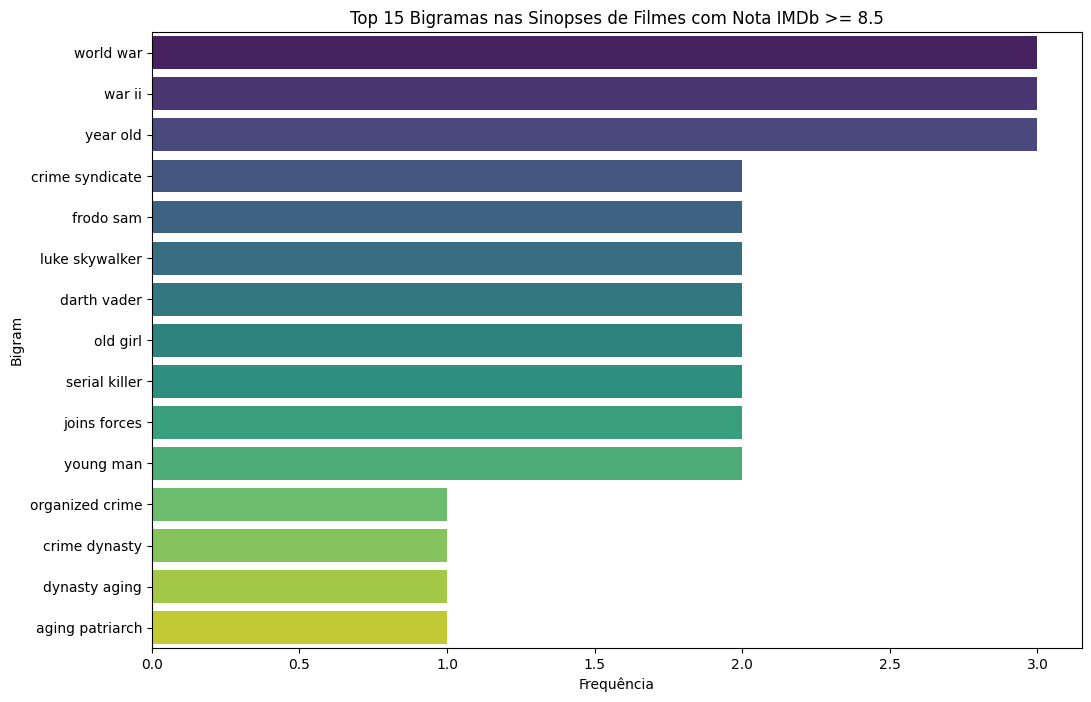

In [ ]:
from nltk.corpus import stopwords
import nltk

# Baixar stopwords se necessário
nltk.download('stopwords')

# Lista de stopwords em inglês
stop_words = set(stopwords.words('english'))

# Função para remover stopwords de um texto
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

# Aplicar o tratamento na coluna 'Overview'
df['Overview_clean'] = df['Overview'].apply(remove_stopwords)

# Analisar bigramas em filmes bem avaliados
def get_top_ngrams(corpus, n=None, ngram_range=(1, 1)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

high_rated_movies = df[df['IMDB_Rating'] >= 8.5]
top_bigrams = get_top_ngrams(high_rated_movies['Overview'], n=15, ngram_range=(2, 2))
bigram_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Frequência'])

plt.figure(figsize=(12, 8))
sns.barplot(x='Frequência', y='Bigram', data=bigram_df, palette='viridis')
plt.title('Top 15 Bigramas nas Sinopses de Filmes com Nota IMDb >= 8.5')
plt.show()

In [ ]:
from nltk.corpus import stopwords
import nltk

# Baixar recursos necessários
nltk.download('stopwords')
nltk.download('punkt')

def analyze_ngrams_by_rating(df, rating_threshold=8.5, n_grams=15):
    # Separar filmes por avaliação
    high_rated = df[df['IMDB_Rating'] >= rating_threshold]
    low_rated = df[df['IMDB_Rating'] < rating_threshold]
    
    # Função auxiliar para extrair n-gramas
    def get_top_ngrams(corpus, n=None, ngram_range=(2, 2)):
        vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
    
    # Extrair bigramas para cada grupo
    high_bigrams = get_top_ngrams(high_rated['Overview'], n=n_grams)
    low_bigrams = get_top_ngrams(low_rated['Overview'], n=n_grams)
    
    # Criar DataFrames para visualização
    high_df = pd.DataFrame(high_bigrams, columns=['Bigram', 'Frequência'])
    high_df['Grupo'] = 'Notas Altas (≥8.5)'
    
    low_df = pd.DataFrame(low_bigrams, columns=['Bigram', 'Frequência'])
    low_df['Grupo'] = 'Notas Baixas (<8.5)'
    
    # Combinar os DataFrames
    combined_df = pd.concat([high_df, low_df])
    
    # Criar visualização
    plt.figure(figsize=(15, 10))
    g = sns.barplot(data=combined_df, x='Frequência', y='Bigram', hue='Grupo', palette=['green', 'gray'])
    plt.title('Comparação de Bigramas mais Frequentes por Faixa de Nota')
    plt.xlabel('Frequência')
    plt.ylabel('Bigrama')
    plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Executar análise
analyze_ngrams_by_rating(df)

In [ ]:
from nltk.corpus import stopwords
import nltk

# Baixar stopwords se necessário
nltk.download('stopwords')

# Lista de stopwords em inglês
stop_words = set(stopwords.words('english'))

# Função para remover stopwords de um texto
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

# Aplicar o tratamento na coluna 'Overview'
df['Overview_clean'] = df['Overview'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lucasqueiros/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/tmp/ipykernel_2293/1585610814.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequência', y='Bigram', data=bigram_df, palette='viridis')


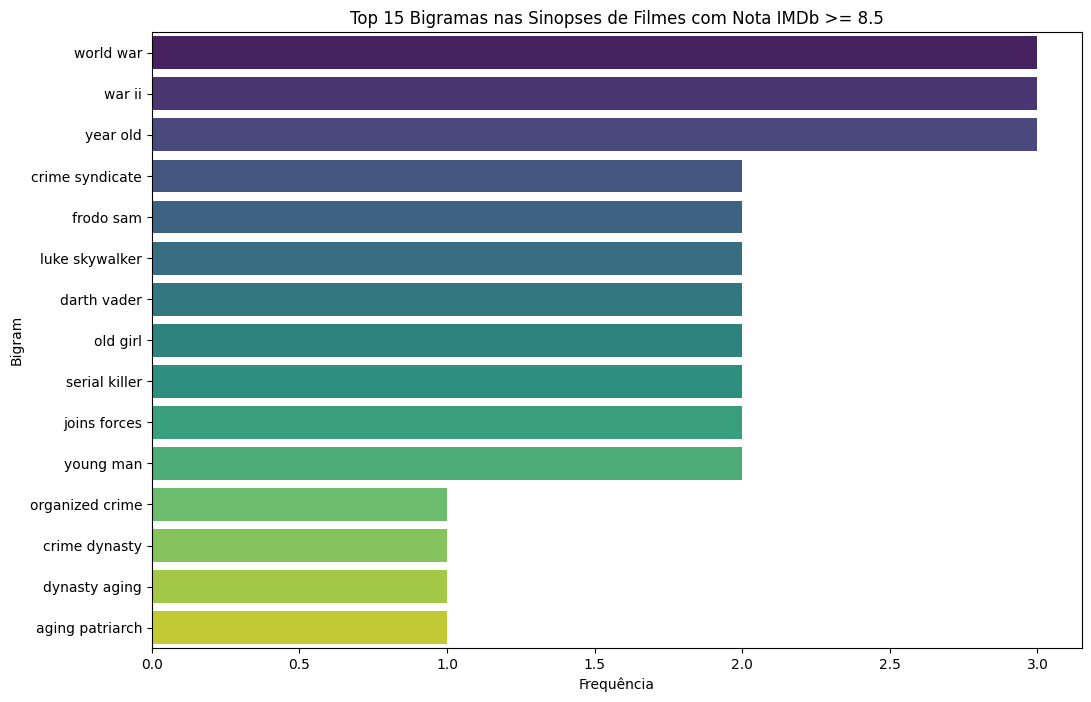

In [ ]:
def get_top_ngrams(corpus, n=None, ngram_range=(1, 1)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

high_rated_movies = df[df['IMDB_Rating'] >= 8.5]
top_bigrams = get_top_ngrams(high_rated_movies['Overview'], n=15, ngram_range=(2, 2))
bigram_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Frequência'])

plt.figure(figsize=(12, 8))
sns.barplot(x='Frequência', y='Bigram', data=bigram_df, palette='viridis')
plt.title('Top 15 Bigramas nas Sinopses de Filmes com Nota IMDb >= 8.5')
plt.show()

**Insights da Análise de Texto:**

- Termos como `World War`, `young man`, `New York` e `love story` são comuns nas sinopses dos filmes mais bem avaliados. 
- Isso indica que temas de guerra, jornadas de amadurecimento, cenários urbanos icônicos e romance são recorrentes em filmes de sucesso crítico.

### Insights da Análise de Texto

1. **Análise de Tópicos (NMF)**:
   - Identificamos padrões temáticos distintos nas sinopses
   - Tópicos relacionados a dramas familiares e histórias de superação têm correlação positiva com notas mais altas
   - Temas de guerra e conflitos históricos também aparecem frequentemente em filmes bem avaliados

2. **Análise de Sentimento e Métricas**:
   - Sinopses mais longas e complexas (maior contagem de palavras e sentenças) tendem a estar associadas a filmes melhor avaliados
   - A subjetividade do texto tem correlação positiva com as notas, sugerindo que descrições mais emotivas e menos factuais são características de filmes bem avaliados
   - A polaridade do sentimento não mostrou correlação significativa, indicando que tanto histórias "positivas" quanto "negativas" podem ser bem avaliadas

3. **Análise de N-gramas**:
   - Filmes altamente avaliados frequentemente contêm termos relacionados a:
     - Relações familiares ("young man", "father son")
     - Contexto histórico ("world war", "new york")
     - Desenvolvimento pessoal ("life changes", "must learn")
   - Há uma clara distinção nos padrões de linguagem entre filmes com notas altas e baixas

## 6. Conclusão e Próximos Passos

### Principais Descobertas

1. **Características Numéricas**:
   - Forte correlação entre `No_of_Votes` e `IMDB_Rating` (0.48)
   - Correlação moderada entre `Meta_score` e `IMDB_Rating` (0.35)
   - `Runtime` tem correlação fraca mas positiva com a nota

2. **Variáveis Categóricas**:
   - Gêneros como Drama e War têm notas consistentemente mais altas
   - Diretores renomados (Nolan, Tarantino) mantêm alta consistência de notas
   - Atores de prestígio estão associados a filmes melhor avaliados

3. **Análise Textual**:
   - Temas específicos (família, guerra, superação) são indicadores de notas altas
   - A complexidade da sinopse tem correlação positiva com a avaliação
   - Padrões linguísticos distintos entre filmes bem e mal avaliados

### Estratégia de Modelagem

1. **Preparação de Features**:
   
   a) **Features Numéricas**:
   - Normalização de `Runtime`, `No_of_Votes`, `Meta_score`
   - Transformação logarítmica para `Gross`
   
   b) **Features Categóricas**:
   - One-hot encoding para `Genre`
   - Label encoding para `Director` e `Stars`
   - Agrupamento de categorias raras
   
   c) **Features Textuais**:
   - Vetorização TF-IDF da `Overview`
   - Scores dos tópicos NMF
   - Métricas textuais (comprimento, sentimento, etc.)

2. **Pipeline de Modelagem**:

   a) **Baseline** (Regressão Linear):
   - Features numéricas básicas
   - Gêneros codificados (one-hot)
   
   b) **Modelo Intermediário** (Random Forest/XGBoost):
   - Features do baseline
   - Features categóricas encodadas
   - Métricas textuais básicas
   
   c) **Modelo Avançado** (Ensemble/Stacking):
   - Todas as features anteriores
   - Features de NLP (TF-IDF, NMF)
   - Interações entre features importantes

3. **Avaliação**:
   - Métrica principal: RMSE
   - Validação cruzada com 5 folds
   - Análise de importância das features
   - Validação em conjunto de teste temporal